In [33]:
#Dwave imports
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite


#Impots for QUBO probelm
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib as plt
import itertools
from itertools import product
from matplotlib import pyplot as plt


Generate all of the possible lines from cart coords, currently doesnt encode vertical lines.

In [17]:
def get_skew_lines(n):
    #Get list of cart coords
    xs = np.linspace(0,n,n,endpoint = False)
    ys = np.linspace(0,n,n,endpoint = False)
    X = product(xs,ys)
    X = np.array(list(X))
    #dx,dy,y_intercept

    lines = []
    for k in range(X.shape[0]):
        for d in range(k,X.shape[0]):
            if X[k][0]-X[d][0] != 0 and X[k][1]-X[d][1] != 0:
                grad = (X[k][1]-X[d][1])/(X[k][0]-X[d][0])
                y_intercept = X[k][1] - grad * X[k][0]
                line = (grad,y_intercept)
                lines.append(line)
    lines = np.array(lines)
    return lines

In [18]:
#Check if a point is on a line (l belongs to delta_l)
def delta_l(i,j,a,b,n):
    if np.round(j - a*i - b, 1) == 0 and i < n and j < n:
        return True
    else: 
        return False

Generate the QUBO matrix, details in my notebook.

In [19]:
def get_Q(n,lines,alpha,beta,gamma,omega):
    Q = np.zeros((n**2,n**2))
    rows = np.linspace(0,n,n,endpoint = False, dtype = 'int32')
    cols = np.linspace(0,n,n,endpoint = False, dtype = 'int32')

#1
    for i in cols:
        for j in rows:
            for s in rows:
                Q[int(i*n+j),int(i*n+s)] += alpha
#2
    for j in rows:
        for i in cols:
            for r in cols:
                Q[int(i*n+j),int(r*n+j)] += beta
#3
    for l in lines:
        a = l[0]
        b = l[1]
        for i in cols:
            for j in rows:
                for r in cols:
                    for s in rows:
                        if delta_l(i,j,a,b,n) & delta_l(r,s,a,b,n):
                            Q[int(i*n+j),int(r*n+s)] += gamma
#4
    for i in rows:
        for j in cols:
            Q[int(i*n+j),int(i*n+j)] -=4*(alpha + beta)
#5
    for l in lines:
        a = l[0]
        b = l[1]
        for i in cols:
            for j in rows:
                if delta_l(i,j,a,b,n):
                    Q[int(i*n+j),int(i*n+j)] -= 4*gamma
#6
    for i in cols:
        for j in rows:
            Q[int(i*n+j),int(i*n+j)] -= 4 * n
            for r in cols:
                for s in rows:
                    Q[int(i*n+j),int(r*n+s)] += omega
    return Q

In [20]:
n = 5
lines = np.unique(get_skew_lines(n),axis = 0)
Q = get_Q(n,lines,1,1,1,4)

In [21]:
def get_lowest_eval(Q):
    w,v = LA.eig(Q)
    g = v[np.argmin(w)]
    print('The lowest energy is' , w[np.argmin(w)])
    return g

In [22]:
def get_lowest_bitstring(Q):
    bin_list = np.array(list(map(list, itertools.product([0, 1], repeat=Q.shape[0]))))[1:]
    energies = []
    for i in range(bin_list.shape[0]):
        E = bin_list[i].T @ Q @ bin_list[i]
        energies.append(E)
    b = bin_list[np.argmin(energies)]
    print('The lowest energy is' , energies[np.argmin(energies)])
    return b,energies

In [23]:
ground_string,energies = get_lowest_bitstring(Q)

The lowest energy is -217.0


In [24]:
def make_img_bit_string(b):
    plt.imshow(b.reshape((n,n)))
    plt.show()
    print(b)

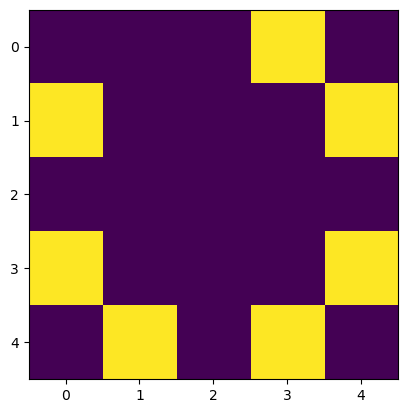

[0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0]


In [25]:
make_img_bit_string(ground_string)

In [26]:
g = get_lowest_eval(Q)
g

The lowest energy is (-66.00000000000009+0j)


array([-1.97647858e-01+0.00000000e+00j,  4.34973208e-02+0.00000000e+00j,
       -8.15050068e-02+0.00000000e+00j,  5.14866783e-17+0.00000000e+00j,
        1.85553178e-01+0.00000000e+00j,  2.07292690e-01+0.00000000e+00j,
       -3.96373000e-16+0.00000000e+00j, -2.43054407e-15+0.00000000e+00j,
        8.58246673e-16+0.00000000e+00j, -1.69304006e-15+0.00000000e+00j,
        4.24642175e-16+0.00000000e+00j, -3.55224904e-15+2.25671849e-15j,
       -3.55224904e-15-2.25671849e-15j,  9.50506559e-02+0.00000000e+00j,
        3.73551715e-15+0.00000000e+00j,  7.59860723e-15+0.00000000e+00j,
        7.59759924e-01+0.00000000e+00j, -3.37727130e-01+0.00000000e+00j,
        1.73687302e-01+0.00000000e+00j,  1.83636098e-01+0.00000000e+00j,
        2.42210003e-15+0.00000000e+00j,  2.81136452e-15+0.00000000e+00j,
       -3.49389254e-16+0.00000000e+00j,  3.07363944e-01+0.00000000e+00j,
       -2.87080283e-01+0.00000000e+00j])

In [27]:
def make_img(g):
    g = abs(g)
    g[g >= 0.1] = 1
    g = np.round_(g, decimals = 0)
    plt.imshow(g.reshape((n,n)))
    plt.show()
    print(g)
    

In [28]:
g

array([-1.97647858e-01+0.00000000e+00j,  4.34973208e-02+0.00000000e+00j,
       -8.15050068e-02+0.00000000e+00j,  5.14866783e-17+0.00000000e+00j,
        1.85553178e-01+0.00000000e+00j,  2.07292690e-01+0.00000000e+00j,
       -3.96373000e-16+0.00000000e+00j, -2.43054407e-15+0.00000000e+00j,
        8.58246673e-16+0.00000000e+00j, -1.69304006e-15+0.00000000e+00j,
        4.24642175e-16+0.00000000e+00j, -3.55224904e-15+2.25671849e-15j,
       -3.55224904e-15-2.25671849e-15j,  9.50506559e-02+0.00000000e+00j,
        3.73551715e-15+0.00000000e+00j,  7.59860723e-15+0.00000000e+00j,
        7.59759924e-01+0.00000000e+00j, -3.37727130e-01+0.00000000e+00j,
        1.73687302e-01+0.00000000e+00j,  1.83636098e-01+0.00000000e+00j,
        2.42210003e-15+0.00000000e+00j,  2.81136452e-15+0.00000000e+00j,
       -3.49389254e-16+0.00000000e+00j,  3.07363944e-01+0.00000000e+00j,
       -2.87080283e-01+0.00000000e+00j])

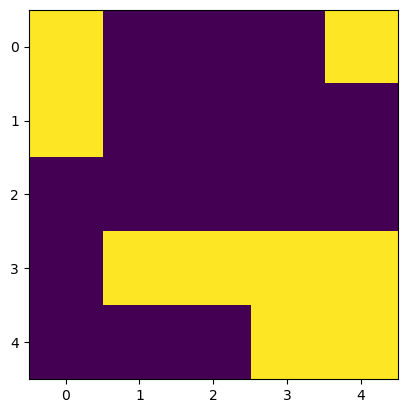

[1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1.]


In [29]:
make_img(g)

In [30]:
lines.shape

(130, 2)

Attempt 2